# dbt Cloud Project and Job Model Build Analysis Notebook

### This Python notebook leverages the robust dbt Cloud APIs to give in-depth analysis on what projects and jobs are producing dbt Cloud model builds
- The goal of this notebook is to provide a template for users to do analysis on their dbt Cloud projects and then alter said analysis into a way that makes sense for their org

Helpful docs:
- [dbt Cloud API Docs](https://docs.getdbt.com/docs/dbt-cloud-apis/overview)
- [dbt Cloud API SDK (dbtc)](https://dbtc.dpguthrie.com/0.4/)

### Importing packages

In [21]:
import pandas as pd
from dbtc import dbtCloudClient
import requests
import json
import math
import matplotlib.pyplot as plt

### define dbt Cloud account info and make connection

In [20]:
# set dbt cloud service token, to make it easier the functions use this as the token name so you cannot change this var name
dbt_cloud_service_token = '<< USE dbt cloud Service Token >>'

# set dbt cloud account id
account_id = 12345

# create connection 
dbt_cloud_client = dbtCloudClient(service_token=dbt_cloud_service_token)

### Creating some lightweight functions to produce dataframe of number of model runs

In [34]:
# creating some dataframe transformations functions

# creating some error handling to use as needed 
class dbtCloudAPICallError(Exception):
    def __init__(self, message):
        self.message = message
        super().__init__(message)

# creating a function to hit the dbt cloud apis to get runs and make it easy to work with
def get_dbt_cloud_runs(account_id, offset=None, limit=None, project_id=None, job_id=None, run_start_date=None, run_end_date=None):

    # url of the api request
    dbt_cloud_runs_url = f"https://cloud.getdbt.com/api/v2/accounts/{account_id}/runs/"

    # defining the array for filter when to get runs
    finished_at_qp = [run_start_date, run_end_date]

    # defining the query parameters
    query_params = f'?limit={limit}&offset={offset}&project_id={project_id}&job_definition_id={job_id}&finished_at__range={finished_at_qp}&status=10&order_by=-finished_at'

    # create the api call URL
    api_call_url = dbt_cloud_runs_url+query_params

    # define headers
    headers = {
        "Authorization": f"Token {dbt_cloud_service_token}"
    }

    # get the response
    api_response = requests.get(api_call_url, headers=headers)

    # return the response data as a dict
    return api_response.json()    

# a function to get all models for a given run
def get_models_for_job_run(run_row):

    gql_query = f'''{{
        job(id: {run_row['job_definition_id']} , runId: {run_row['id']}) {{
            models{{ name }}
            }}
        }}'''
    
    models_num = dbt_cloud_client.metadata.query(gql_query)

    try:
        models_num_list = models_num['data']['job']['models']
    except:
        models_num_list = []

    return models_num_list


# a function to count all models in a given run
def cnt_models_for_job_run(run_row):

    return len(run_row['models_in_run'])


# function to figure out how many runs need to be pulled
def get_runs_upper_limit(account_id, project_id=None, job_id=None, run_start_date=None, run_end_date=None):

    # get the runs for the given query. Adding some super simple error handling to help people out
    try:

        # get the api return
        account_runs_query = get_dbt_cloud_runs(account_id, offset=0, limit=1, project_id=project_id, job_id=job_id, run_start_date=run_start_date, run_end_date=run_end_date)

        # get the run of runs for the query
        account_runs_upper = account_runs_query['extra']['pagination']['total_count']

    except Exception as e:    
        error_message = f"""There was an error when making the dbt Cloud API Call or parsing the data that was returned.
                           This is likely due to trying to pass an incorrect project id or job id to the function OR an incorrect account ID or dbt Cloud Service token.
                           Please check to make sure the project and job id you are passing into the function are correct.
                           Also double check your account ID and dbt Cloud Service token.

                           The error message coming back is the following:
                           {e}

                           If this is a key error for 'extra' that means you have an incorrect account id, project id, or job id.
        """

        # raise the error
        raise dbtCloudAPICallError(error_message)


    # get the number of times we'll need to paginate
    number_of_offsets = (account_runs_upper/100)

    # number of offsets uniform
    number_of_offsets_uni = math.ceil(number_of_offsets)

    # return the number of offsets
    return {"offsets" : number_of_offsets_uni}


# creating a function that will get models for runs for the account level, project level, and job level
def gather_model_run_info_for_account_df(account_id, offset_num, limit=100, project_id=None, job_id=None, run_start_date=None, run_end_date=None):

    # return the requested runs
    run_info = get_dbt_cloud_runs(account_id, offset=offset_num, limit=limit, project_id=project_id, job_id=job_id, run_start_date=run_start_date, run_end_date=run_end_date)['data']

    # turn the results into a dataframe
    run_info_df = pd.DataFrame.from_dict(run_info)[["id", "project_id", "job_definition_id", "finished_at", "is_complete", "is_success"]]

    # return the dataframe
    return run_info_df



# creating a function to get the proper number of results, turn the into a df, and union them
def turn_run_results_into_consolidated_df(account_id, project_id=None, job_id=None, run_start_date=None, run_end_date=None):
    
    # getting the number_of_offsets required for what is needed
    offset_info = get_runs_upper_limit(account_id=account_id, project_id=project_id, job_id=job_id, run_start_date=run_start_date, run_end_date=run_end_date)

    # offset range
    offset_range = range(offset_info['offsets'])

    # looping thru and getting data into a single dataframe

    for intr in offset_range:

        # get first cut of dataframe
        if intr == 0 and intr != max(offset_range):

            # get the first runs df
            runs_df = gather_model_run_info_for_account_df(account_id, offset_num=0, project_id=project_id, job_id=job_id, run_start_date=run_start_date, run_end_date=run_end_date)


        elif intr == 0 and intr == max(offset_range):

             # get the first runs df
            runs_df = gather_model_run_info_for_account_df(account_id, offset_num=0, project_id=project_id, job_id=job_id, run_start_date=run_start_date, run_end_date=run_end_date)

        elif intr > 0 and intr != max(offset_range): 

            # getting next runs df
            runs_df_union = gather_model_run_info_for_account_df(account_id, offset_num=(intr*100), project_id=project_id, job_id=job_id, run_start_date=run_start_date, run_end_date=run_end_date)

            # union into first runs df
            runs_df = pd.concat([runs_df, runs_df_union])

        else:

             # getting next runs df
            runs_df_union = gather_model_run_info_for_account_df(account_id, offset_num=(intr*100), project_id=project_id, job_id=job_id, run_start_date=run_start_date, run_end_date=run_end_date)

            # union to first runs df
            runs_df = pd.concat([runs_df, runs_df_union])

    # filter to make sure we only look at completed and sucessful runs
    cleaned_runs_df = runs_df.query('is_complete == True & is_success == True')

    # return the final result
    return cleaned_runs_df


# # creating a function to take the fun run results and add additonal model information
def add_models_and_counts_into_df(runs_df):

    # apply the getting models to df
    runs_df['models_in_run'] = runs_df.apply(get_models_for_job_run, axis=1)

    # adding a count of models 
    runs_df['cnt_models_for_job_run'] = runs_df.apply(cnt_models_for_job_run, axis=1)

    # return the results
    return runs_df


# creating a function to pull it all together (one function to make life easy)
def get_runs_for_a_dbt_cloud_account(account_id, project_id=None, job_id=None, run_start_date=None, run_end_date=None):

    # getting the data for the data
    dbt_cloud_runs = turn_run_results_into_consolidated_df(account_id=account_id, project_id=project_id, job_id=job_id, run_start_date=run_start_date, run_end_date=run_end_date)

    # adding to the dataframe to get model info
    run_and_model_df = add_models_and_counts_into_df(dbt_cloud_runs)

    # return the df
    return run_and_model_df

### Doing analysis of model builds at the account level

In [24]:
# getting runs from sep 1 to nov 1 to analyze
run_start_date = '2023-09-01'
run_end_date = '2023-11-01'

# note this will take a little since we are making a few API calls
dbt_cloud_account_runs = get_runs_for_a_dbt_cloud_account(account_id=account_id, run_start_date=run_start_date, run_end_date=run_end_date)

# Set the maximum number of rows to display, just using to reduce notebook size when demoing
# pd.set_option('display.max_rows', 4)

# display the data to get a look at it
display(dbt_cloud_account_runs)

,id,project_id,job_definition_id,finished_at,is_complete,is_success,models_in_run,cnt_models_for_job_run
0,211402602,131392,106102,2023-10-31 21:44:28.927787+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
1,210369351,131392,106102,2023-10-29 04:02:32.635433+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
...,...,...,...,...,...,...,...,...
41,191175816,131392,211981,2023-09-07 19:43:04.292859+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",31
42,189469994,131392,106102,2023-09-03 04:02:13.443421+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",31


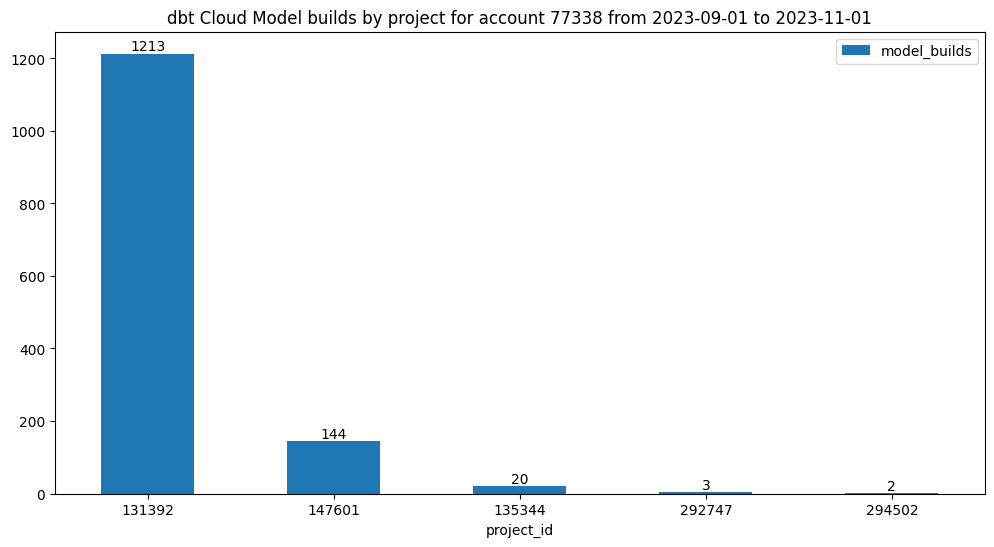

In [25]:
# grouping the data frame by project
project_model_builds = dbt_cloud_account_runs[['project_id','cnt_models_for_job_run']].groupby(['project_id'], as_index=False).sum()

# rename the fields
project_model_builds.rename(columns={'cnt_models_for_job_run': 'model_builds'}, inplace=True)

# ordering them by desc
ordered_project_model_builds = project_model_builds.sort_values(by='model_builds', ascending=False)

# creating a graph title
graph_title = f"dbt Cloud Model builds by project for account {account_id} from {run_start_date} to {run_end_date}"
 
# viz the data 
ax = ordered_project_model_builds.plot.bar(x='project_id', y='model_builds', rot=0, figsize=(12, 6), title=graph_title)

# add data labels
for p in ax.patches:
        ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')


# display the chart 
plt.show()

### Doing analysis of model builds at the project level

In [27]:
# getting runs from sep 1 to nov 1 for project 131392
run_start_date = '2023-09-01'
run_end_date = '2023-11-01'
dbt_cloud_project_id=131392

# note this will take a little since we are making a few API calls
dbt_cloud_project_runs = get_runs_for_a_dbt_cloud_account(account_id=account_id, project_id=dbt_cloud_project_id, run_start_date=run_start_date, run_end_date=run_end_date)

# display the data to get a look at it
display(dbt_cloud_project_runs)

,id,project_id,job_definition_id,finished_at,is_complete,is_success,models_in_run,cnt_models_for_job_run
0,211402602,131392,106102,2023-10-31 21:44:28.927787+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
1,210369351,131392,106102,2023-10-29 04:02:32.635433+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
...,...,...,...,...,...,...,...,...
36,191175816,131392,211981,2023-09-07 19:43:04.292859+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",31
37,189469994,131392,106102,2023-09-03 04:02:13.443421+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",31


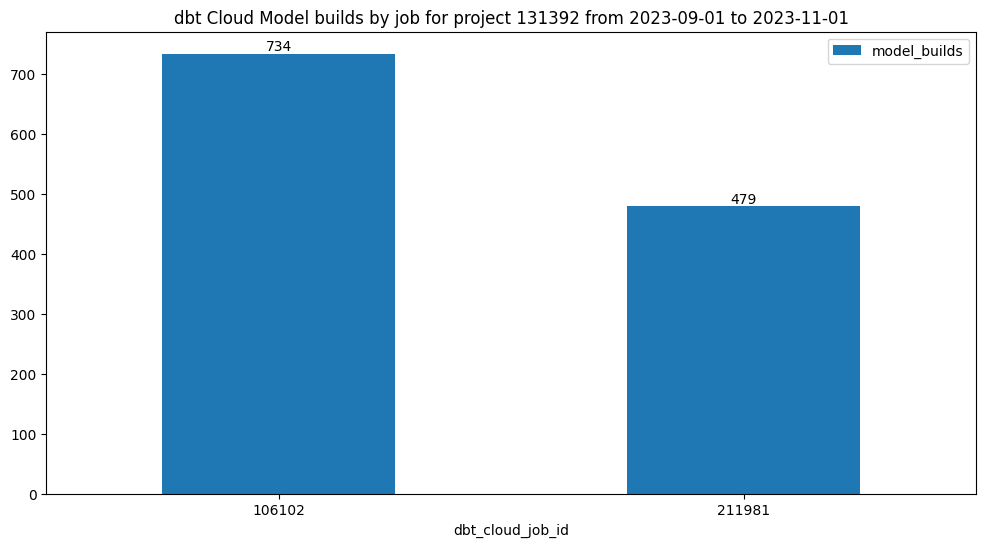

In [28]:
# grouping the data frame by project
project_model_builds = dbt_cloud_project_runs[['job_definition_id','cnt_models_for_job_run']].groupby(['job_definition_id'], as_index=False).sum()

# rename the fields
project_model_builds.rename(columns={'cnt_models_for_job_run': 'model_builds', 'job_definition_id' : 'dbt_cloud_job_id'}, inplace=True)

# ordering them by desc
ordered_project_model_builds = project_model_builds.sort_values(by='model_builds', ascending=False)

# creating a graph title
graph_title = f"dbt Cloud Model builds by job for project {dbt_cloud_project_id} from {run_start_date} to {run_end_date}"
 
# viz the data 
ax = ordered_project_model_builds.plot.bar(x='dbt_cloud_job_id', y='model_builds', 
                                           rot=0, figsize=(12, 6), title=graph_title)

# add data labels
for p in ax.patches:
        ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')


# display the chart 
plt.show()

### Doing analysis of model builds at the job level

In [32]:
# getting runs from sep 1 to nov 1 for project 131392
run_start_date = '2023-09-01'
run_end_date = '2023-11-01'
dbt_cloud_project_id=131392
dbt_cloud_job_id = 211981

# note this will take a little since we are making a few API calls
dbt_cloud_job_runs = get_runs_for_a_dbt_cloud_account(account_id=account_id, project_id=dbt_cloud_project_id, job_id=dbt_cloud_job_id, run_start_date=run_start_date, run_end_date=run_end_date)

# display the data to get a look at it
display(dbt_cloud_job_runs)

,id,project_id,job_definition_id,finished_at,is_complete,is_success,models_in_run,cnt_models_for_job_run
0,209426263,131392,211981,2023-10-26 15:13:40.105909+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
1,209414933,131392,211981,2023-10-26 14:36:11.568577+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
...,...,...,...,...,...,...,...,...
13,193298339,131392,211981,2023-09-13 15:31:08.865064+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",32
14,191175816,131392,211981,2023-09-07 19:43:04.292859+00:00,True,True,"[{'name': 'a_sample_model'}, {'name': 'a_small...",31


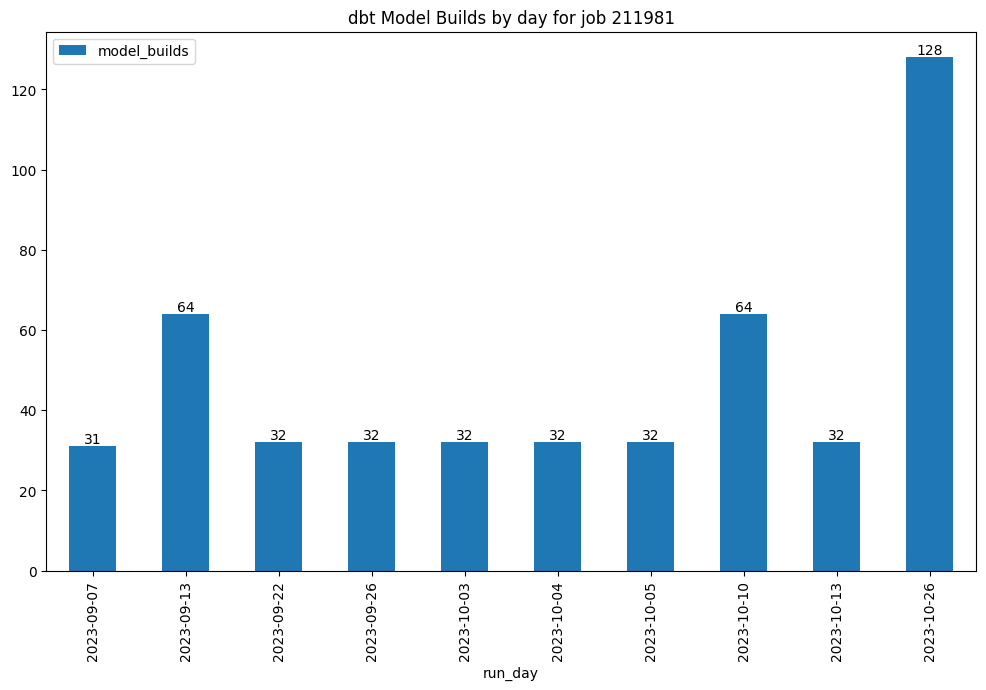

In [33]:
# adding a field that converts the timestamp column and truncates it
dbt_cloud_job_runs['run_day'] = (pd.to_datetime(dbt_cloud_job_runs['finished_at']).dt.floor('d')).dt.date

# grouping the data frame by day to make a time series
job_builds_by_date = dbt_cloud_job_runs[['run_day','cnt_models_for_job_run']].groupby(['run_day'], as_index=False).sum()

# rename the fields
job_builds_by_date.rename(columns={'cnt_models_for_job_run': 'model_builds'}, inplace=True)

# ordering them by day
ordered_job_builds_by_date = job_builds_by_date.sort_values(by='run_day', ascending=True)


# viz the data 
ax = ordered_job_builds_by_date.plot.bar(x='run_day', y='model_builds', 
                                           rot=0, figsize=(12, 7), title="dbt Model Builds by day for job 211981")

# add data labels
for p in ax.patches:
        ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
        
plt.xticks(rotation=90) 

plt.show()


___

# END OF SCRIPT
___